In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [61]:
# DATA_PATH = '../data/training/final/travel_ml.csv'
DATA_PATH = '../data/training/final/travel_insight_pruned.csv'
# VAL_DATA_PATH = '../data/validation/final/travel_ml.csv'
travel = pd.read_csv(DATA_PATH)
# travel_val = pd.read_csv(VAL_DATA_PATH)
travel.head()

,TRAVEL_ID,TRAVEL_LENGTH,total_payment,visit_move_cnt,IS_FAILED_TRIP,total_payment_per_day,visit_move_cnt_per_day
0,a_a014262,2,0.014607,5,1,0.246732,2.50
1,a_a006728,2,-0.310801,5,0,-0.269297,2.50
2,a_a015745,4,-0.345055,19,0,-0.452622,4.75
3,a_a010544,2,-0.250857,9,0,-0.174239,4.50
4,a_a012058,2,-0.062463,5,0,0.124515,2.50


In [62]:
# 학습에 사용할 피처값 선언
BINARY_CLASSIFICATION_TARGET = 'IS_FAILED_TRIP'

BINARY_CLASSIFICATION_FEATURES = [
    'TRAVEL_LENGTH',
    'visit_move_cnt',
    'total_payment',
    'total_payment_per_day',
    'visit_move_cnt_per_day'
]

In [63]:
# 데이터 선언
X = travel[BINARY_CLASSIFICATION_FEATURES]
y = travel[BINARY_CLASSIFICATION_TARGET]

In [64]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3
)

In [65]:
# Hyperparameter 최적화를 위해 Optuna
import optuna
# Optuna를 사용한 Hyperparameter 최적화
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
import numpy as np

# 1. Objective 함수 정의
# Optuna는 이 함수를 호출하여 각기 다른 하이퍼파라미터 조합으로 모델을 평가합니다.
# 이 함수의 반환값(성능 점수)을 최대화하는 하이퍼파라미터를 찾게 됩니다.
def objective(trial):
    """
    Optuna가 최적의 하이퍼파라미터를 찾기 위해 사용하는 함수입니다.
    trial 객체를 통해 탐색할 하이퍼파라미터의 범위와 종류를 지정합니다.
    """
    # 클래스 불균형 비율(양성:실패) 보정
    pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    
    # 하이퍼파라미터 탐색 공간을 정의합니다.
    # trial.suggest_... API를 사용하여 각 파라미터의 탐색 범위와 타입을 지정합니다.
    param = {
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': pos_weight,
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0)
    }

    # 모델 생성
    model = XGBClassifier(**param)

    # 교차 검증(Cross-validation)을 통해 모델의 성능을 안정적으로 평가합니다.
    # 데이터를 여러 번 나누어 학습하고 평가하여 일반화 성능을 측정합니다.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = []
    # K-fold 교차 검증 수행
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # 모델 학습. 사용자 환경의 XGBoost 버전과 호환성을 위해 조기 종료 기능은 제외합니다.
        model.fit(X_train_fold, y_train_fold)
        
        # 예측 확률 계산 및 성능 평가 (PR-AUC)
        preds = model.predict_proba(X_val_fold)[:, 1]
        pr_auc = average_precision_score(y_val_fold, preds)
        scores.append(pr_auc)

    # 교차 검증 점수들의 평균을 반환합니다. Optuna는 이 점수를 최대화하는 방향으로 탐색을 진행합니다.
    return np.mean(scores)

# 2. Study 생성 및 최적화 실행
# 'direction'을 'maximize'로 설정하여 objective 함수가 반환하는 점수가 높은 쪽으로 최적화를 진행합니다.
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='maximize', study_name='xgb_optimization')

# 'n_trials'는 하이퍼파라미터 조합을 몇 번이나 시도해볼지 결정하는 값입니다.
study.optimize(objective, n_trials=40) # 기존 RandomizedSearchCV와 유사하게 40회 시도

# 3. 최적화 결과 확인
print("Optimization finished.")
print('Best trial:')
best_trial = study.best_trial

print(f'  Value (PR-AUC): {best_trial.value:.4f}')
print('  Best Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# 4. 최적의 하이퍼파라미터로 모델 재학습
# 찾은 최적의 하이퍼파라미터로 전체 학습 데이터에 대해 모델을 다시 학습합니다.
print("Training the best model on the full training data...")
best_params = best_trial.params
# objective 함수 내에서 고정했던 파라미터들을 다시 추가해줍니다.
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
best_params['scale_pos_weight'] = pos_weight
best_params['objective'] = 'binary:logistic'
best_params['tree_method'] = 'hist'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
print("Best model trained successfully.")

[I 2025-09-27 13:14:33,462] A new study created in memory with name: xgb_optimization


Starting hyperparameter optimization with Optuna...


[I 2025-09-27 13:14:39,082] Trial 0 finished with value: 0.07931963562948219 and parameters: {'n_estimators': 800, 'learning_rate': 0.027130254466418917, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.8809967085622579, 'colsample_bytree': 0.9793541155845932, 'gamma': 0.9667570726681571, 'reg_lambda': 1.0424435472527016, 'reg_alpha': 0.4533074497846491}. Best is trial 0 with value: 0.07931963562948219.
[I 2025-09-27 13:14:41,237] Trial 1 finished with value: 0.08652013745025537 and parameters: {'n_estimators': 600, 'learning_rate': 0.101810000047188, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.6803180361946951, 'colsample_bytree': 0.6378766196456599, 'gamma': 0.21287132107544882, 'reg_lambda': 0.9718987877234286, 'reg_alpha': 0.08728030156923583}. Best is trial 1 with value: 0.08652013745025537.
[I 2025-09-27 13:14:46,428] Trial 2 finished with value: 0.08547326445348151 and parameters: {'n_estimators': 900, 'learning_rate': 0.01113515412307041, 'max_depth': 5, 'min_chi

Optimization finished.
Best trial:
  Value (PR-AUC): 0.1023
  Best Params: 
    n_estimators: 500
    learning_rate: 0.04693186294940394
    max_depth: 3
    min_child_weight: 7
    subsample: 0.8096193279019748
    colsample_bytree: 0.7744637215562545
    gamma: 0.9414324736108155
    reg_lambda: 0.826738139257822
    reg_alpha: 0.3880209124660534
Training the best model on the full training data...
Best model trained successfully.


In [66]:
# 베스트 모델 평가 (Train/Test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score

threshold = 0.5  # lower this value to predict more failed (1) travels
y_proba_train_gs = best_model.predict_proba(X_train)[:,1]
y_proba_test_gs = best_model.predict_proba(X_test)[:,1]
y_pred_train_gs = (y_proba_train_gs >= threshold).astype(int)
y_pred_test_gs = (y_proba_test_gs >= threshold).astype(int)
print(f'Decision threshold: {threshold:.2f}')
print('='*5+'Train (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_train, y_pred_train_gs):.4f}')
print('Confusion Matrix')
print(confusion_matrix(y_train, y_pred_train_gs))
print(classification_report(y_train, y_pred_train_gs))
print(f'ROC-AUC : {roc_auc_score(y_train, y_proba_train_gs):.4f}')
print(f'PR-AUC  : {average_precision_score(y_train, y_proba_train_gs):.4f}')
print('='*5+'Test (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_test, y_pred_test_gs):.4f}')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test_gs))
print(classification_report(y_test, y_pred_test_gs))
print(f'ROC-AUC : {roc_auc_score(y_test, y_proba_test_gs):.4f}')
print(f'PR-AUC  : {average_precision_score(y_test, y_proba_test_gs):.4f}')

Decision threshold: 0.50
=====Train (BestModel)======================================================================
Acc : 0.7805
Confusion Matrix
[[2991  868]
 [  17  155]]
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      3859
           1       0.15      0.90      0.26       172

    accuracy                           0.78      4031
   macro avg       0.57      0.84      0.57      4031
weighted avg       0.96      0.78      0.85      4031

ROC-AUC : 0.9033
PR-AUC  : 0.2689
=====Test (BestModel)======================================================================
Acc : 0.7483
Confusion Matrix
[[1258  391]
 [  44   35]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      1649
           1       0.08      0.44      0.14        79

    accuracy                           0.75      1728
   macro avg       0.52      0.60      0.50      1728
weighted avg       0.93      0.75      0.82

In [67]:
# True positive rows (predict=1 & true=1)
import pandas as pd

y_pred_test_series = pd.Series(y_pred_test_gs, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test_gs, index=X_test.index, name='predicted_proba')
tp_mask = (y_test == 1) & (y_pred_test_series == 1)
tp_df = X_test.loc[tp_mask].copy()
tp_df['actual'] = y_test.loc[tp_mask]
tp_df['predicted'] = y_pred_test_series.loc[tp_mask]
tp_df['predicted_proba'] = y_proba_test_series.loc[tp_mask]
print(f'Total true positives in test set: {tp_df.shape[0]}')
tp_df.to_csv('TP_traveler.csv')

Total true positives in test set: 35


In [68]:
# True negative rows (predict=0 & true=0)
import pandas as pd

y_pred_test_series = pd.Series(y_pred_test_gs, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test_gs, index=X_test.index, name='predicted_proba')
tn_mask = (y_test == 0) & (y_pred_test_series == 0)
tn_df = X_test.loc[tn_mask].copy()
tn_df['actual'] = y_test.loc[tn_mask]
tn_df['predicted'] = y_pred_test_series.loc[tn_mask]
tn_df['predicted_proba'] = y_proba_test_series.loc[tn_mask]
print(f'Total true positives in test set: {tn_df.shape[0]}')
tn_df.to_csv('TN_traveler.csv')

Total true positives in test set: 1258


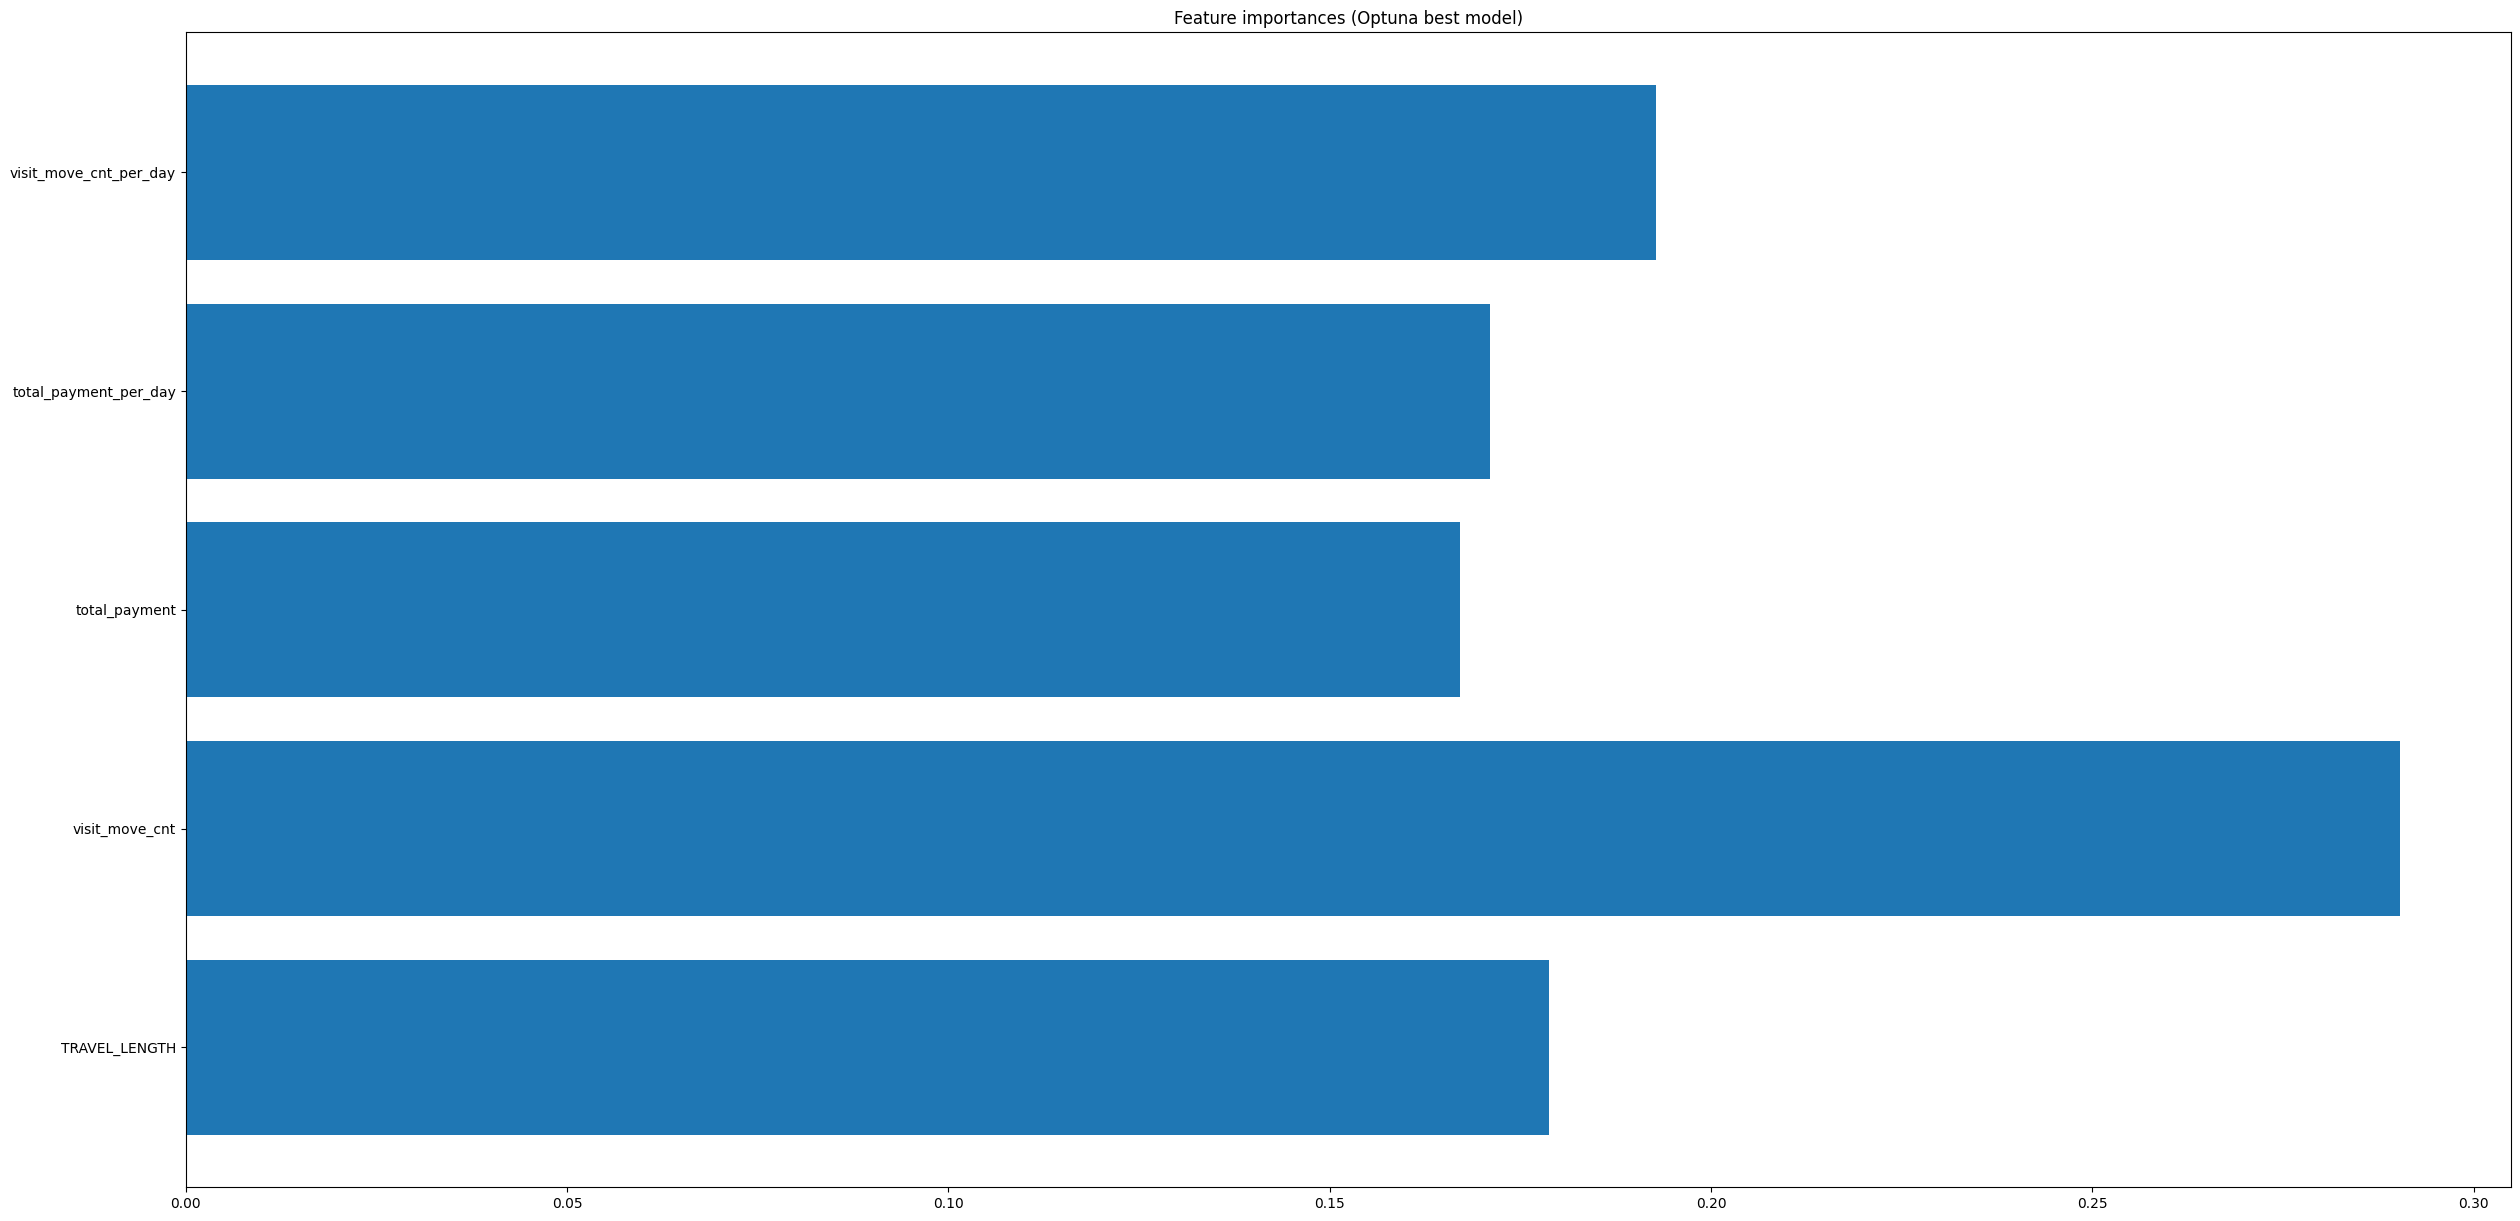

visit_move_cnt            0.290373
visit_move_cnt_per_day    0.192771
TRAVEL_LENGTH             0.178814
total_payment_per_day     0.170974
total_payment             0.167069
dtype: float32


In [69]:
# 특성 중요도 (베스트 모델)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,15))
plt.barh(X.columns, best_model.feature_importances_)
plt.title('Feature importances (Optuna best model)')
plt.show()

feat_imp = best_model.feature_importances_
feat_names = X_train.columns
feat_imp_ser = pd.Series(feat_imp, index=feat_names)

sorted_feature_importances = feat_imp_ser.sort_values(ascending=False)
print(sorted_feature_importances)

In [70]:
# True negative rows (predict=0 & true=0)
tn_mask = (y_test == 0) & (y_pred_test_series == 0)
tn_df = X_test.loc[tn_mask].copy()
tn_df['actual'] = y_test.loc[tn_mask]
tn_df['predicted'] = y_pred_test_series.loc[tn_mask]
tn_df['predicted_proba'] = y_proba_test_series.loc[tn_mask]
print(f'Total true negatives in test set: {tn_df.shape[0]}')
tn_df

Total true negatives in test set: 1258


,TRAVEL_LENGTH,visit_move_cnt,total_payment,total_payment_per_day,visit_move_cnt_per_day,actual,predicted,predicted_proba
4629,3,18,1.190645,1.213908,6.000000,0,0,0.002706
3176,3,15,-0.293674,-0.355301,5.000000,0,0,0.015119
5545,2,6,-0.165224,-0.038442,3.000000,0,0,0.305991
1097,3,8,-0.019646,-0.065601,2.666667,0,0,0.184960
3935,3,8,0.545537,0.531906,2.666667,0,0,0.095006
...,...,...,...,...,...,...,...,...
1151,3,8,0.514138,0.498711,2.666667,0,0,0.089559
2347,3,6,1.164955,1.186749,2.000000,0,0,0.054950
3235,4,16,1.025086,0.633753,4.000000,0,0,0.415606
3592,2,8,-0.190914,-0.079181,4.000000,0,0,0.052757
